# ECE 685D, Fall 2020 
## Problem Set 2 

## Full name: Guillem Amat Castello


In [7]:
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn import mixture, preprocessing, metrics
import seaborn as sns
from typing import List
import numpy as np
import pandas as pd
import pdb

In [8]:
import warnings
warnings.simplefilter('ignore')

<br>

### Problem 2 (Gaussian Mixture Model)

We will first produce the GMM Mixture Model with the specified parameters

In [9]:
# Defining Mixture Model parameters
phi = [0.125, 0.125, 0.5, 0.25]
mu = [np.array([0, 0]), np.array([0,2]), np.array([2,0]), np.array([2,2])]
sigma = [np.array([[0.2, 0.1],[0.1,0.2]]),
         np.array([[0.1, -0.15],[-0.15,0.3]]),
         np.array([[0.3, 0.05],[0.05,0.3]]),
         np.identity(2)*0.15]

In [10]:
def GMM_fit(sample_size:int, phi: List[float], mu: List[np.array], sigma) -> List[np.array]:
    GMM = np.zeros((sample_size, 2))
    k = np.random.choice(len(phi), sample_size, p = phi)
    for i in range(len(k)):
        value = np.random.multivariate_normal(mu[k[i]], sigma[k[i]])
        GMM[i][0] = value[0]
        GMM[i][1] = value[1]
    return GMM

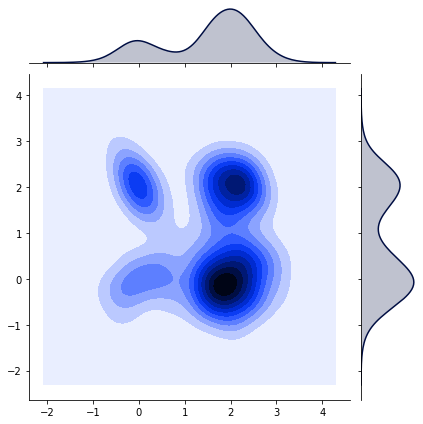

In [13]:
# We will plot the samples with the given values to check how they looks
GMM_sample = GMM_fit(10**3, phi, mu, sigma)
sns.jointplot(x=GMM_sample[:, 0], y=GMM_sample[:, 1], kind='kde', color = '#000E43')

<br>

We will now proceed to calculate the log-likelihood for different values of K.

In [14]:
log_likelihood = {}

for k in np.arange(1,8):
    GMM = mixture.GaussianMixture(n_components = k)
    GMM.fit(GMM_sample)
    log_likelihood[k] = GMM.score(GMM_sample) 

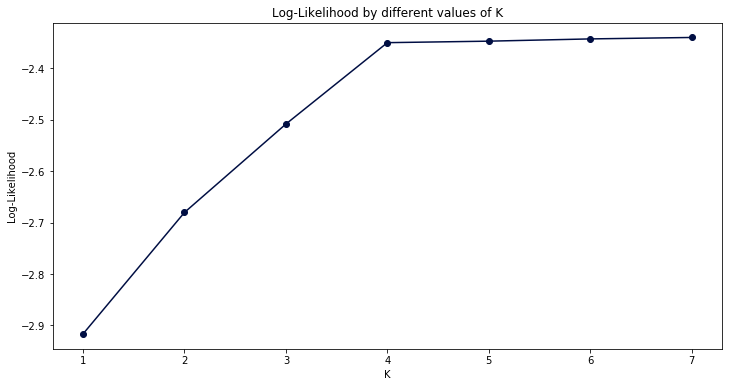

In [15]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(1,8), list(log_likelihood.values()), marker = 'o', color='#000E43')
plt.title("Log-Likelihood by different values of K")
plt.xlabel("K")
plt.ylabel("Log-Likelihood")
plt.show()

<br>

<br>

### Problem 4 (Bias-variance trade-off)

**Part 1**

In [16]:
M = np.arange(1, 16)
X_train = np.arange(0, 1, step = .2)
y_train = np.array([np.sin(2*x*np.pi) + np.cos(4*x*np.pi) for x in X_train])
X_test = np.arange(0, 1, step = .01)
y_test = np.array([np.sin(2*x*np.pi) + np.cos(4*x*np.pi) for x in X_test])

In [17]:
sse_train = []
sse_test = []

In [18]:
#with warnings.simplefilter('ignore', np.RankWarning):
for m in M:
    polinomial = np.polyfit(X_train, y_train, m)
    sse_train.append(np.sum((np.polyval(polinomial, X_train)-y_train)**2))
    sse_test.append(np.sum((np.polyval(polinomial, X_test)-y_test)**2))

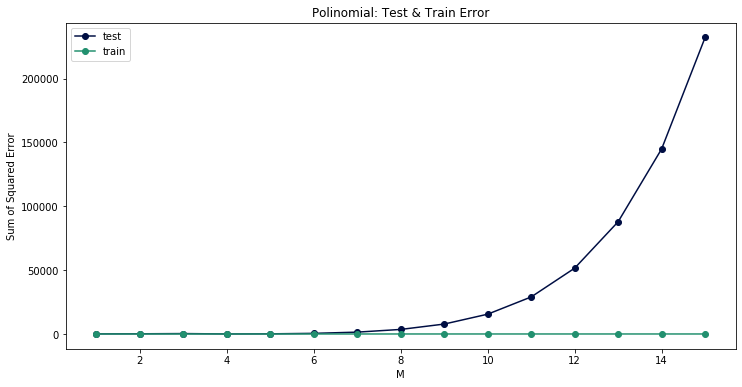

In [19]:
plt.figure(figsize=(12,6))
plt.plot(M, sse_test, marker = 'o', color='#000E43', label = 'test')
plt.plot(M, sse_train, marker = 'o', color='#22906F', label = 'train')
plt.title("Polinomial: Test & Train Error")
plt.xlabel("M")
plt.ylabel("Sum of Squared Error")
plt.legend()
plt.show()

<br>

**Part 2**

In [20]:
M = 14
lambdas = np.linspace(0.01, 50, 50)
log_lambdas = np.log(lambdas)

In [21]:
M_polinomial = preprocessing.PolynomialFeatures(14)
X_reg_train = M_polinomial.fit_transform(X_train.reshape(-1,1))
X_reg_test = M_polinomial.fit_transform(X_test.reshape(-1,1))

In [22]:
sse_reg_train = []
sse_reg_test = []

In [23]:
for l in lambdas:
    Ridge_Regressor = Ridge(fit_intercept = False, alpha = l)
    Ridge_Regressor.fit(X_reg_train, y_train)
    train_error = np.sum((y_train - Ridge_Regressor.predict(X_reg_train))**2)
    sse_reg_train.append(train_error)
    test_error = np.sum((y_test - Ridge_Regressor.predict(X_reg_test))**2)
    sse_reg_test.append(test_error)

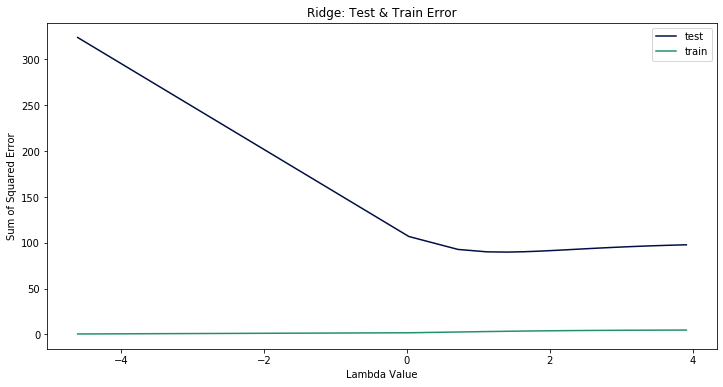

In [24]:
plt.figure(figsize=(12,6))
plt.plot(log_lambdas, sse_reg_test, color='#000E43', label = 'test')
plt.plot(log_lambdas, sse_reg_train, color='#22906F', label = 'train')
plt.title("Ridge: Test & Train Error")
plt.xlabel("Lambda Value")
plt.ylabel("Sum of Squared Error")
plt.legend()
plt.show()

<br>

### Problem 6 (Nonlinear Basis Functions)

In [25]:
#GMM1
phi_1 = [1]
mu_1 = [np.array([0, 0])]
sigma_1 = [0.1*np.identity(2)]
GMM1 = GMM_fit(100, phi_1, mu_1, sigma_1)

In [26]:
#GMM2
phi_2 = [0.5, 0.5]
mu_2 = [np.array([-1, -1]), np.array([1,1])]
sigma_2 = [0.1*np.identity(2),
           0.1*np.identity(2)]
GMM2 = GMM_fit(200, phi_2, mu_2, sigma_2)

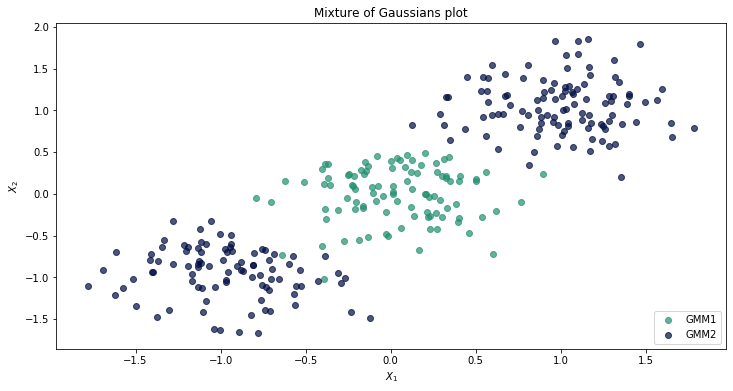

In [27]:
plt.figure(figsize=(12,6))
plt.scatter(GMM1[:, 0], GMM1[:, 1], c = '#22906F', alpha = 0.7, label = 'GMM1') 
plt.scatter(GMM2[:, 0], GMM2[:, 1], c = '#000E43', alpha = 0.70, label = 'GMM2')
plt.title("Mixture of Gaussians plot")
plt.xlabel("$X_{1}$")
plt.ylabel("$X_{2}$")
plt.legend(loc = 'lower right')
plt.show()

We are not able to linearly separate the two different datasets. We will need to apply a transformation in order to do so.

In [28]:
def transform_GMM(GMM_sample: np.array, mu = List[np.array]) -> np.array:
    #pdb.set_trace()
    transformed_GMM = np.zeros((GMM_sample.shape[0], GMM_sample.shape[1]))
    for i in range(transformed_GMM.shape[0]):
        transformed_GMM[i][0] = np.exp(-0.5 * np.dot((GMM_sample[i]-mu[0]),(GMM_sample[i]-mu[0]).T))
        transformed_GMM[i][1] = np.exp(-0.5 * np.dot((GMM_sample[i]-mu[1]),(GMM_sample[i]-mu[1]).T))
    return transformed_GMM       

In [29]:
mu = [*mu_1, mu_2[0]]
GMM1_t = transform_GMM(GMM1, mu)
GMM2_t = transform_GMM(GMM2, mu)

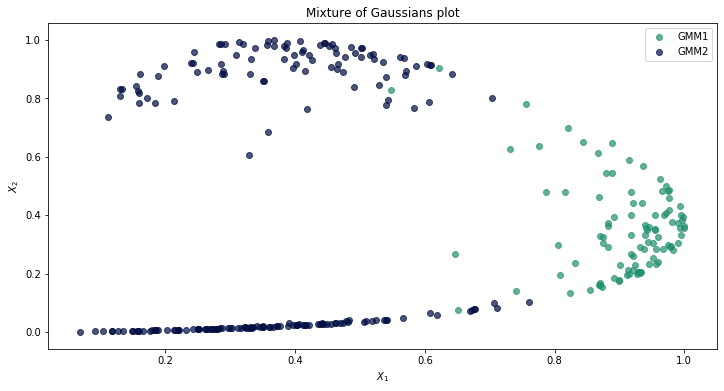

In [30]:
plt.figure(figsize=(12,6))
plt.scatter(GMM1_t[:, 0], GMM1_t[:, 1], c = '#22906F', alpha = 0.7, label = 'GMM1') 
plt.scatter(GMM2_t[:, 0], GMM2_t[:, 1], c = '#000E43', alpha = 0.70, label = 'GMM2')
plt.title("Mixture of Gaussians plot")
plt.xlabel("$X_{1}$")
plt.ylabel("$X_{2}$")
plt.legend()
plt.show()